# PartI：构建决策树、使用决策树

#### **1 预测隐形眼镜类型**

使用lenses.txt中的隐形眼镜数据集，采用第三章中介绍的ID3算法构建决策树。
    
使用决策树，输入几组隐形眼镜特征数据，
    
例如：'young','hyper','no','reduced'，'pre','hyper','no','normal'；等进行测试，预测隐形眼镜类型。 


In [1]:
import math
import matplotlib.pyplot as plt

'''决策树显示时的图形定义'''
decision_node = dict(boxstyle="sawtooth", fc="1")
leaf_node = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

'''从txt读取数据集到列表'''
def load_dataset(path):
    file_to_line = open(path).readlines()  #从lenses.txt读取行数据到变量
    number_of_lines = len(file_to_line)  #得到文件的行数
    dataset = []  #数据集
    for line in file_to_line:  #遍历行，读取为列表
        line = line.strip()
        list_from_line = line.split('\t')
        dataset.append(list_from_line)
    return dataset
'''计算信息熵，返回熵值'''
def shannon_entropy(dataset):
    num = len(dataset)  #数据的个数
    label_count = {}  # 利用字典存储每个种类的数量
    for item in dataset:
        current_label = item[-1]
        if current_label not in label_count.keys():  #若种类没被统计过，则加入字典
            label_count[current_label] = 0
        label_count[current_label] += 1
    shannon_ent = 0.0
    for key in label_count:
        prob = float(label_count[key]) / num
        shannon_ent -= prob * math.log(prob, 2)  #  H = - sigma(p*log(p))
    return shannon_ent
'''按照特定特征划分数据集'''
def split_dataset(dataset, axis, value):
    splited_dataset = []  #划分后的数据集
    for feature in dataset:
        if feature[axis] == value:
            reduced_feature = feature[:axis]
            reduced_feature.extend(feature[axis + 1:])
            splited_dataset.append(reduced_feature)
    return splited_dataset
'''选择划分数据集的方式，主要是选择划分的特征'''
def get_best_feature(dataset):
    feature_num = len(dataset[0]) - 1  # 获得数据集特征数量
    base_entropy = shannon_entropy(dataset)  # 原始的信息熵
    best_info_gain = 0
    best_feature = -1
    for i in range(feature_num):
        feature_list = [fea[i] for fea in dataset]
        new_entropy = 0
        vals = set(feature_list)  # vals为一个不重复的特征集合
        for value in vals:  #对vals集合中的每个种类计算信息熵，累加
            sub_dataset = split_dataset(dataset, i, value)
            prob = len(sub_dataset) / float(len(dataset))
            new_entropy += prob * shannon_entropy(sub_dataset)
        info_gain = base_entropy - new_entropy
        if (info_gain > best_info_gain):  # 取信息增益最大的特征为最佳特征
            best_info_gain = info_gain
            best_feature = i
    return best_feature
'''采用多数表决的方法对类标签不唯一的叶子节点进行定义'''
def majority_cnt(class_list):
    class_count = {}
    for vote in class_list:
        if vote not in class_count.keys():
            class_count[vote] = 0
        class_count[vote] += 1
    sorted_class_count = sorted(class_count.iteritems(),
                                key=operator.itemgetter(1),
                                reverse=True)
    return sorted_class_count[0][0]
'''创建决策树'''
def create_tree(dataset, label):
    class_list = [item[-1] for item in dataset]
    if class_list.count(class_list[0]) == len(class_list):
        return class_list[0]  #类别完全相同时，不再划分
    if len(dataset[0]) == 1:
        return majority_cnt(class_list)  #特征遍历完返回种类最多的类别
    best_feature = get_best_feature(dataset)
    best_feature_label = label[best_feature]
    my_tree = {best_feature_label: {}}
    del (label[best_feature])
    feature_values = [example[best_feature] for example in dataset]
    vals = set(feature_values)
    for value in vals:
        sub_label = label[:]  #复制属性
        my_tree[best_feature_label][value] = create_tree(
            split_dataset(dataset, best_feature, value), sub_label)
    return my_tree
'''测试决策树'''
def classify(input_tree, feature_label, test_vector):
    first_str = list(input_tree.keys())[0]
    second_dict = input_tree[first_str]
    feat_index = feature_label.index(first_str)
    key = test_vector[feat_index]
    value_of_feature = second_dict[key]
    if isinstance(value_of_feature, dict):
        class_label = classify(value_of_feature, feature_label, test_vector)
    else:
        class_label = value_of_feature
    return class_label
'''获取叶节点的数量'''
def get_num_leafs(my_tree):
    num_leafs = 0
    first_str = list(my_tree.keys())[0]
    second_dict = my_tree[first_str]
    for key in second_dict.keys():
        if type(
                second_dict[key]
        ).__name__ == 'dict':  #test to see if the nodes are dictonaires, if not they are leaf nodes
            num_leafs += get_num_leafs(second_dict[key])
        else:
            num_leafs += 1
    return num_leafs
'''获取树的深度'''
def get_tree_depth(my_tree):
    max_depth = 0
    first_str = list(my_tree.keys())[0]
    second_dict = my_tree[first_str]
    for key in second_dict.keys():
        if type(
                second_dict[key]
        ).__name__ == 'dict':  #test to see if the nodes are dictonaires, if not they are leaf nodes
            this_depth = 1 + get_tree_depth(second_dict[key])
        else:
            this_depth = 1
        if this_depth > max_depth: max_depth = this_depth
    return max_depth
'''节点的标签'''
def plot_node(node_txt, center_pt, parent_pt, node_type):
    create_plot.ax1.annotate(node_txt,
                             xy=parent_pt,
                             xycoords='axes fraction',
                             xytext=center_pt,
                             textcoords='axes fraction',
                             va="center",
                             ha="center",
                             bbox=node_type,
                             arrowprops=arrow_args)
'''树的标签'''
def plot_mid_text(cntr_pt, parent_pt, txt_string):
    x_mid = (parent_pt[0] - cntr_pt[0]) / 2.0 + cntr_pt[0]
    y_mid = (parent_pt[1] - cntr_pt[1]) / 2.0 + cntr_pt[1]
    create_plot.ax1.text(x_mid,
                         y_mid,
                         txt_string,
                         va="center",
                         ha="center",
                         rotation=30)
'''绘制决策树'''
def plot_tree(my_tree, parent_pt,node_txt):  #if the first key tells you what feat was split on
    num_leafs = get_num_leafs(
        my_tree)  #this determines the x width of this tree
    depth = get_tree_depth(my_tree)
    first_str = list(
        my_tree.keys())[0]  #the text label for this node should be this
    cntr_pt = (plot_tree.xOff +
               (1.0 + float(num_leafs)) / 2.0 / plot_tree.totalW,
               plot_tree.yOff)
    plot_mid_text(cntr_pt, parent_pt, node_txt)
    plot_node(first_str, cntr_pt, parent_pt, decision_node)
    second_dict = my_tree[first_str]
    plot_tree.yOff = plot_tree.yOff - 1.0 / plot_tree.totalD
    for key in second_dict.keys():
        if type(
                second_dict[key]
        ).__name__ == 'dict':  #test to see if the nodes are dictonaires, if not they are leaf nodes
            plot_tree(second_dict[key], cntr_pt, str(key))  #recursion
        else:  #it's a leaf node print the leaf node
            plot_tree.xOff = plot_tree.xOff + 1.0 / plot_tree.totalW
            plot_node(second_dict[key], (plot_tree.xOff, plot_tree.yOff),
                      cntr_pt, leaf_node)
            plot_mid_text((plot_tree.xOff, plot_tree.yOff), cntr_pt, str(key))
    plot_tree.yOff = plot_tree.yOff + 1.0 / plot_tree.totalD
'''显示绘制的决策树'''
def create_plot(in_tree):
    fig = plt.figure(figsize=(10,10), facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    create_plot.ax1 = plt.subplot(111, frameon=False, **axprops)  #no ticks
    plot_tree.totalW = float(get_num_leafs(in_tree))
    plot_tree.totalD = float(get_tree_depth(in_tree))
    plot_tree.xOff = -0.5 / plot_tree.totalW
    plot_tree.yOff = 1.0
    plot_tree(in_tree, (0.5, 1.0), '')
    plt.show()

In [2]:
dataset = load_dataset('lenses.txt')  #加载数据集
dataset

[['young', 'myope', 'no', 'reduced', 'no lenses'],
 ['young', 'myope', 'no', 'normal', 'soft'],
 ['young', 'myope', 'yes', 'reduced', 'no lenses'],
 ['young', 'myope', 'yes', 'normal', 'hard'],
 ['young', 'hyper', 'no', 'reduced', 'no lenses'],
 ['young', 'hyper', 'no', 'normal', 'soft'],
 ['young', 'hyper', 'yes', 'reduced', 'no lenses'],
 ['young', 'hyper', 'yes', 'normal', 'hard'],
 ['pre', 'myope', 'no', 'reduced', 'no lenses'],
 ['pre', 'myope', 'no', 'normal', 'soft'],
 ['pre', 'myope', 'yes', 'reduced', 'no lenses'],
 ['pre', 'myope', 'yes', 'normal', 'hard'],
 ['pre', 'hyper', 'no', 'reduced', 'no lenses'],
 ['pre', 'hyper', 'no', 'normal', 'soft'],
 ['pre', 'hyper', 'yes', 'reduced', 'no lenses'],
 ['pre', 'hyper', 'yes', 'normal', 'no lenses'],
 ['presbyopic', 'myope', 'no', 'reduced', 'no lenses'],
 ['presbyopic', 'myope', 'no', 'normal', 'no lenses'],
 ['presbyopic', 'myope', 'yes', 'reduced', 'no lenses'],
 ['presbyopic', 'myope', 'yes', 'normal', 'hard'],
 ['presbyopic', 

In [3]:
label = ['age', 'prescript', 'astigmatic', 'tear rate']  #数据集标签
feature_label = label.copy()  #保留标签
my_tree = create_tree(dataset, label)  #构造决策树
my_tree

{'tear rate': {'reduced': 'no lenses',
  'normal': {'astigmatic': {'no': {'age': {'pre': 'soft',
      'young': 'soft',
      'presbyopic': {'prescript': {'myope': 'no lenses', 'hyper': 'soft'}}}},
    'yes': {'prescript': {'myope': 'hard',
      'hyper': {'age': {'pre': 'no lenses',
        'young': 'hard',
        'presbyopic': 'no lenses'}}}}}}}}

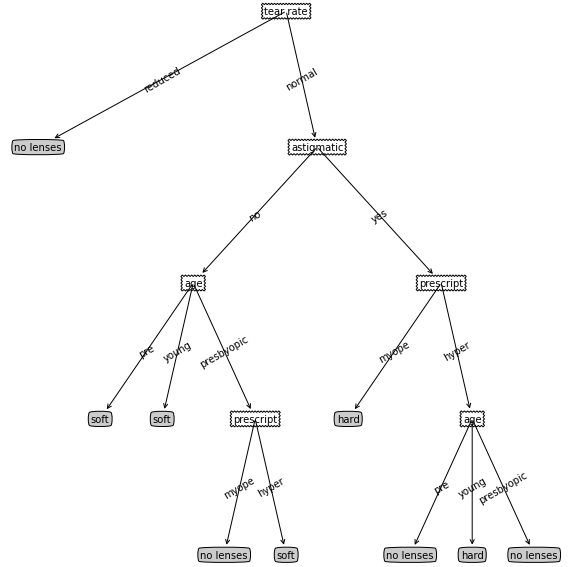

In [4]:
create_plot(my_tree)

In [5]:
# 输入两个测试数据，测试决策树
test_vec1 = ['young', 'hyper', 'yes', 'normal']
test_vec2 = ['pre', 'myope', 'yes', 'reduced']
result1 = classify(my_tree, feature_label, test_vec1)
result2 = classify(my_tree, feature_label, test_vec2)
result1, result2

('hard', 'no lenses')

#### **2 利用机器学习库sklearn中的决策树分类器DecisionTreeClassifier对Iris数据集进行交叉验证，测试其准确率。**


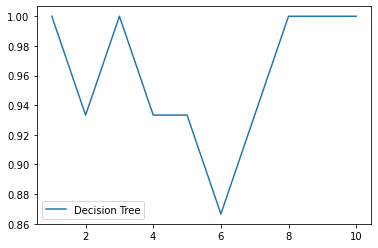

模型测试集准确率为： 0.96


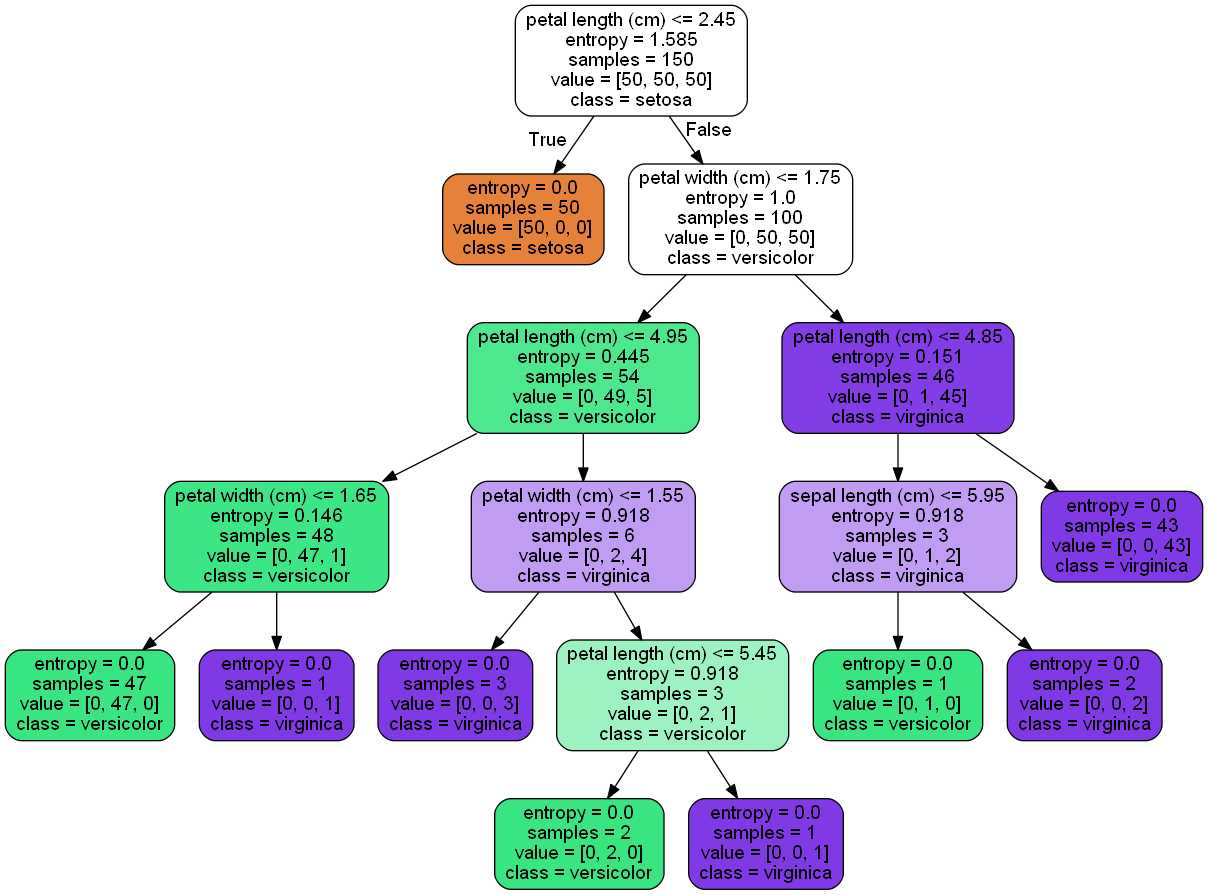

In [6]:
from sklearn import datasets# 数据集
from sklearn.model_selection import train_test_split# 训练集测试集分割模块
from sklearn import tree# 分类器
import graphviz # 绘制决策树
from sklearn.model_selection import cross_val_score
from IPython.display import display,Image
from six import StringIO
import pydotplus

# 读入数据集
iris = datasets.load_iris()
#读取特征
iris_dataset = iris.data
#读取结果
iris_target = iris.target
# 特征名称
iris_feature = iris.feature_names
# 类名
iris_names = iris.target_names
# # 分割数据集
# test_rate = 0.3  # 测试集比例
# x_train, x_test, y_train, y_test = train_test_split(iris_dataset,iris_target,test_size= test_rate)

# 设置决策树分类器
clf = tree.DecisionTreeClassifier(criterion="entropy")

# 交叉验证 ，取10个互补的子集
clf_s = cross_val_score(clf,iris_dataset,iris_target,cv=10)
# 可视化结果
plt.plot(range(1,11),clf_s,label = "Decision Tree")
plt.legend()
plt.show()
# 最终准确率取平均值
print("模型测试集准确率为：", np.mean(clf_s))


# 绘制决策树模型
clf.fit(iris_dataset,iris_target)
dot_data=StringIO()
clf_dot = tree.export_graphviz(clf,out_file= dot_data,feature_names= iris_feature,class_names= iris_names,filled= True,rounded= True)
# 显示绘制的模型
graph=pydotplus.graph_from_dot_data(dot_data.getvalue())
display(Image(graph.create_png()))

#### **3 利用机器学习库sklearn中的随机森林分类器RandomForestClassifier对Iris数据集进行交叉验证，测试其准确率。**

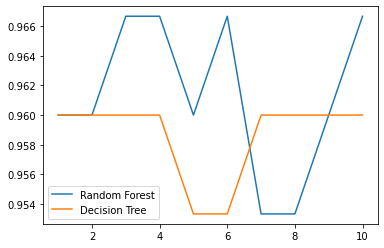

模型测试集准确率为： 0.9613333333333332


In [7]:
from sklearn.ensemble import RandomForestClassifier  # 导入随机森林分类器
from sklearn.model_selection import train_test_split  # 训练集测试集分割模块
from sklearn.preprocessing import StandardScaler  # 数据的标准化
import numpy as np
from sklearn import datasets  # 数据集
import graphviz  # 绘制决策树
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
# 读入数据集
iris = datasets.load_iris()
#读取特征
iris_dataset = iris.data
#读取标签
iris_target = iris.target
# 特征名称
iris_feature = iris.feature_names
# 类名
iris_names = iris.target_names

# 设置决策树分类器
clf = RandomForestClassifier()
# 进行10次循环，每次利用交叉验证的方式，最后取平均值
rfc_l = []
clf_l = []
for i in range(10):
    rfc = RandomForestClassifier(n_estimators=25)
    rfc_s = cross_val_score(rfc, iris_dataset, iris_target, cv=10).mean()
    rfc_l.append(rfc_s)
    clf = DecisionTreeClassifier()
    clf_s = cross_val_score(clf, iris_dataset, iris_target, cv=10).mean()
    clf_l.append(clf_s)
plt.plot(range(1, 11), rfc_l, label="Random Forest")
plt.plot(range(1, 11), clf_l, label="Decision Tree")
plt.legend()
plt.show()

print("模型测试集准确率为：", np.mean(rfc_l))

# PartII：使用朴素贝叶斯过滤垃圾邮件

#### **4 垃圾邮件过滤。**
使用email文件夹下spam文件夹(垃圾邮件)和ham文件夹（正常邮件）的共50个邮件，

采用交叉验证的方式，随机选取10个文件作为测试数据，其他作为训练数据，

采用朴素贝叶斯进行垃圾邮件的分类。计算多次迭代后的平均错误率

In [8]:
import re
import random
from numpy import *

'''输入字符串，输出小写单词列表'''
def text_parse(big_string):
    list_of_tokens = re.split(r'\W+', big_string)
    # 书中用的是\W*，用这个来切分文本时发现，将文本切成了一个字母一个字母的样子，并没有完整的单词
    return [tok.lower() for tok in list_of_tokens
            if len(tok) > 2]  #去掉少于两个字符的单词，并把单词全部变为小写，返回单词列表
'''去除单词列表中的重复项，生成词汇表'''
def create_vocab_list(data_set):
    vocab_set = set([])  #空集合
    for document in data_set:
        vocab_set = vocab_set | set(document)  #求两个集合的并集
    return list(vocab_set)
'''基于词袋模型的朴素贝叶斯,输出向量包含每个词出现的次数'''
def bag_of_words_2_vecMN(vocab_list, input_set):
    return_vec = [0] * len(vocab_list)
    for word in input_set:
        if word in vocab_list:
            return_vec[vocab_list.index(word)] += 1
    return return_vec
'''朴素贝叶斯分类器训练'''
def train_naive_bayes(train_matrix, train_category):
    num_train_docs = len(train_matrix)
    num_words = len(train_matrix[0])
    p_spam = sum(train_category) / float(num_train_docs)  # 计算文档属于spam的概率
    p0_num = ones(num_words)  # 分子
    p1_num = ones(num_words)
    p0_denom = 2.0  # 分母
    p1_denom = 2.0  
    for i in range(num_train_docs):
        if train_category[i] == 1:
            p1_num += train_matrix[i]
            p1_denom += sum(train_matrix[i])
        else:
            p0_num += train_matrix[i]
            p0_denom += sum(train_matrix[i])
    p1_vect = log(p1_num / p1_denom)  #change to log()
    p0_vect = log(p0_num / p0_denom)  #change to log()
    return p0_vect, p1_vect, p_spam
'''朴素贝叶斯分类函数'''
def classify_naive_bayes(vec_2_classify, p0_vec, p1_vec, p_class1):
    p1 = sum(vec_2_classify * p1_vec) + log(p_class1)  #element-wise mult
    p0 = sum(vec_2_classify * p0_vec) + log(1.0 - p_class1)
    if p1 > p0:
        return 1
    else:
        return 0
'''邮件分分类主函数'''
def spam_classify():
    #首先导入，解析文本
    doc_list = []
    class_list = []
    full_text = []
    for i in range(1, 26):  # spam 与 ham分别共25封，设置1~26
        word_list = text_parse(open('email/spam/%d.txt' %
                                    i).read())  #读取txt，返回小写单词列表
        doc_list.append(word_list)  # append ：加入列表对象
        full_text.extend(word_list)  # extend：wordlist中的单词扩展入full_data
        class_list.append(1)  # 1代表垃圾邮件
        word_list = text_parse(open('email/ham/%d.txt' % i).read())
        doc_list.append(word_list)
        full_text.extend(word_list)
        class_list.append(0)  # 0代表正常邮件
    vocab_list = create_vocab_list(doc_list)  #生成词汇表，包含50封邮件所有词汇（>2个字母，小写）
    training_set = list(range(50))  #python2 -> python3 需要修改，训练集（邮件序号）
    test_set = []  #测试集（邮件序号）
    for i in range(10):
        rand_index = int(random.uniform(0, len(training_set)))  #随机取10封邮件作为测试集
        test_set.append(training_set[rand_index])
        del (training_set[rand_index])
    train_mat = []
    train_classes = []
    for doc_index in training_set:  #训练分类器
        train_mat.append(bag_of_words_2_vecMN(vocab_list, doc_list[doc_index]))
        train_classes.append(class_list[doc_index])
    p0v, p1v, p_spam = train_naive_bayes(array(train_mat),
                                         array(train_classes))
    error_count = 0
    for doc_index in test_set:  #进行测试
        word_vector = bag_of_words_2_vecMN(vocab_list, doc_list[doc_index])
        if classify_naive_bayes(array(word_vector), p0v, p1v,
                                p_spam) != class_list[doc_index]:
            error_count += 1
    return float(error_count) / len(test_set)

In [9]:
'''单次测试'''
error = spam_classify()
print('分类错误率 = ' + str(error))

分类错误率 = 0.1


In [10]:
'''多次迭代重复计算错误率 '''
size  = 100 #迭代次数
err = [] #存放每次的错误率
for i in range(size):
    err.append(spam_classify())
error_rate = average(err)
print('多次迭代后平均分类错误率 = ' + str(error_rate)) 

多次迭代后平均分类错误率 = 0.061999999999999986


#### **5 采用sklearn中的MultinomialNB朴素贝叶斯算法对sklearn的datasets中自带的digits数据集进行分类，测试分类效果。**

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
#载入digits数据集
digits = load_digits()
# 读取数据集，
digits_data, dagits_target = digits.data, digits.target
# 分割数据集
test_rate = 0.3 # 测试集比例
x_train,x_test,y_train,y_test = train_test_split(digits_data,dagits_target,test_size=test_rate)

# 设置MultinomialNB朴素贝叶斯分类器
clf = MultinomialNB()
# 训练模型
clf.fit(x_train, y_train)
# 评价模型
score = clf.score(x_test, y_test)
print("模型测试集准确率为：", score)

模型测试集准确率为： 0.8907407407407407


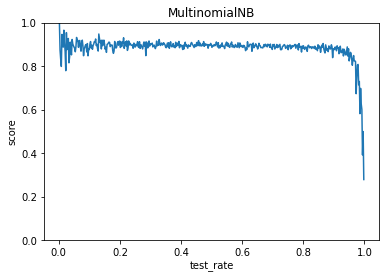

In [12]:
'''测试 MultinomialNB 的预测性能随测试集所占比的变化'''
def test_MultinomialNB():
    # 分割数据集
    test_rate=np.linspace(0.002,0.998,num=480)

    train_scores=[]
    test_scores=[]
    for i in test_rate:
        x_train,x_test,y_train,y_test = train_test_split(digits_data,dagits_target,test_size=i)
        cls=MultinomialNB()
        cls.fit(x_train,y_train)
        test_scores.append(cls.score(x_test, y_test))

    ## 绘图
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    ax.plot(test_rate,test_scores,label="Testing Score")
    ax.set_xlabel("test_rate")
    ax.set_ylabel("score")
    ax.set_ylim(0,1.0)
    ax.set_title("MultinomialNB")
    plt.show()
    
# 调用 test_MultinomialNB
test_MultinomialNB()